<a href="https://colab.research.google.com/github/Gabriela2685/Articulo/blob/main/C%C3%B3digo_accidentes_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código utilizado para la implementación del modelo predictivo de accidentes en la Ciudad de México durante el 2023

Carmen Gabriela Angulo Payán

Versión Python 3.10.12

Última revisión enero 13, 2025


In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

#Modelos Poisson y Binomial Negativa

In [36]:
# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})  # Mapear días de la semana a valores numéricos
data['festivo'] = data['festivo'].map({'SI': 1, 'NO': 0})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ np.log(TPDA_aprox) + p_no_semaforizada + p_semaforizada + dia_2 +"""
          """interseccion_Y + interseccion_T + interseccion_X"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Calcular el VIF (Multicolinealidad)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
#print("VIF para cada variable:\n", vif_data)

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
#print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  292
Model:                            GLM   Df Residuals:                      284
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -985.27
Date:                Tue, 14 Jan 2025   Deviance:                       15.501
Time:                        04:48:50   Pearson chi2:                     15.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9774
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.3070      0

<ipython-input-36-fc6199be3a82>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


#Gráficos

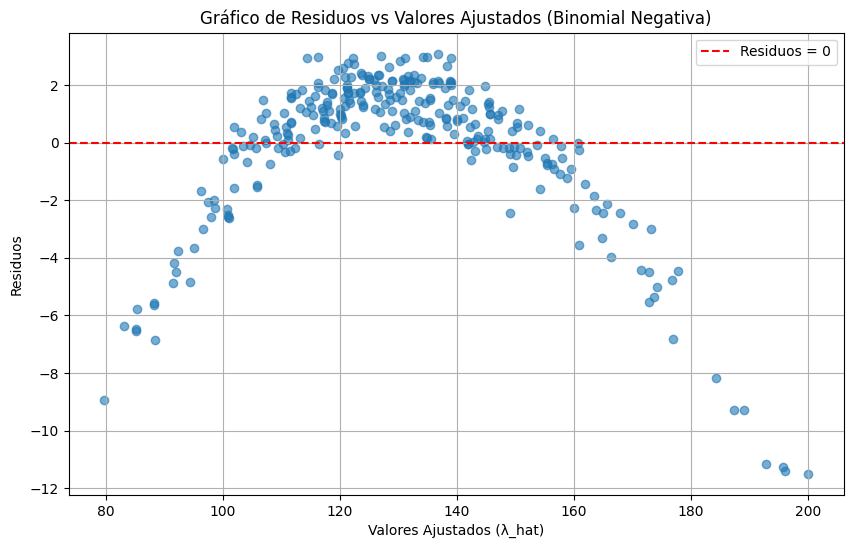

In [37]:
# Evaluación de residuos del modelo de Binomial Negativa
train_data['residuos'] = nb2_model.resid_response
plt.figure(figsize=(10, 6))
plt.scatter(train_data['lambda_hat'], train_data['residuos'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Residuos = 0')
plt.title('Gráfico de Residuos vs Valores Ajustados (Binomial Negativa)')
plt.xlabel('Valores Ajustados (λ_hat)')
plt.ylabel('Residuos')
plt.legend()
plt.grid()
plt.show()

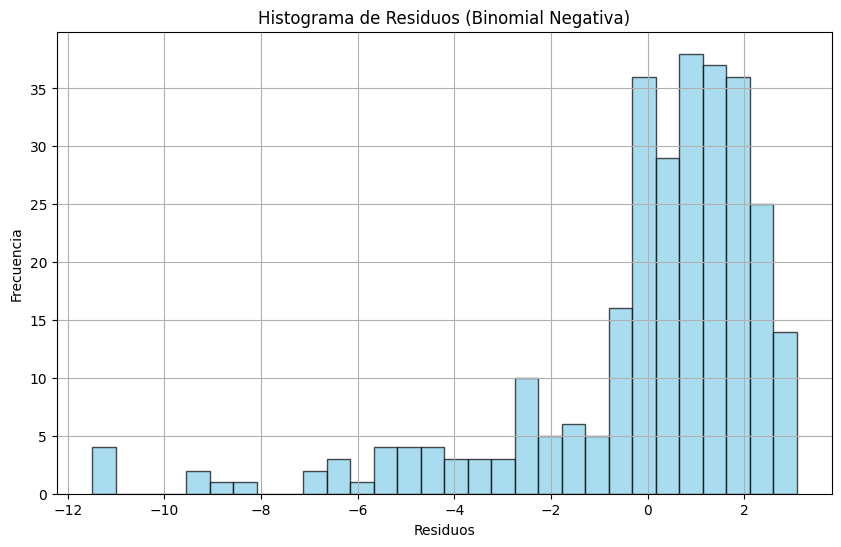

In [38]:
# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(train_data['residuos'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma de Residuos (Binomial Negativa)')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

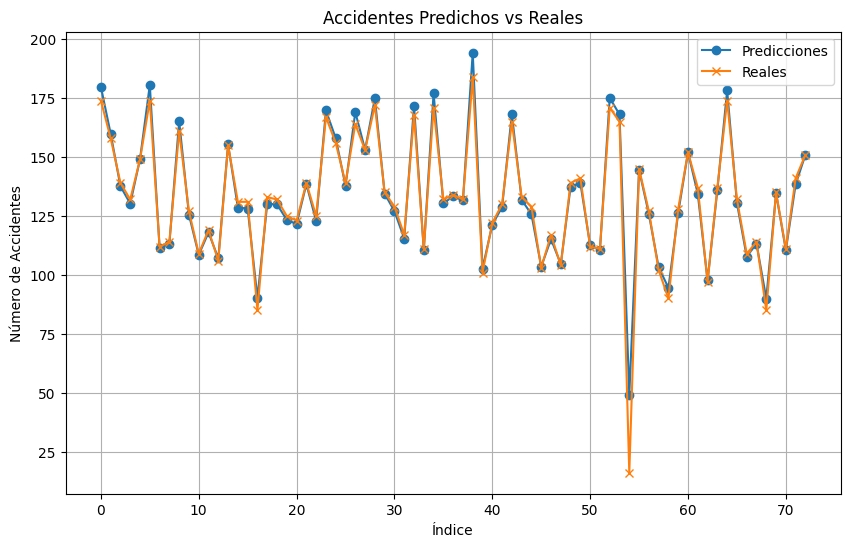

In [39]:
# Visualizar resultados: Predicciones vs Reales
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()

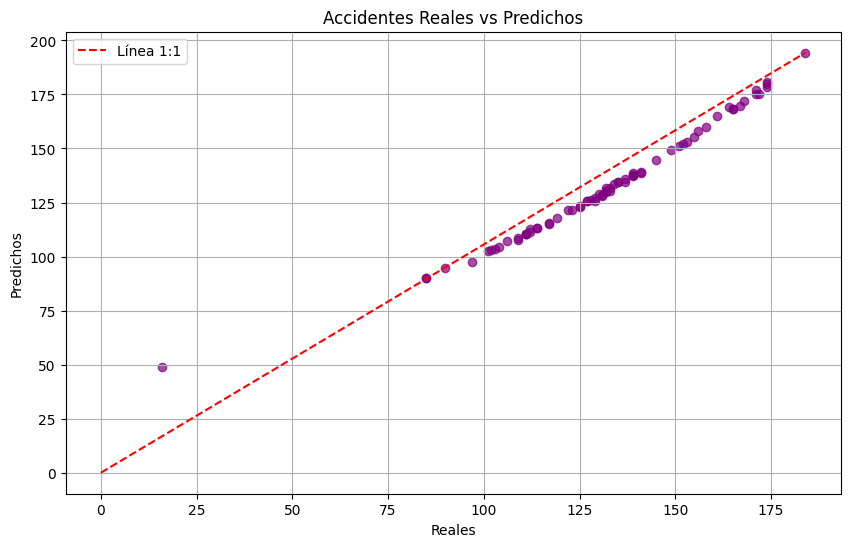

In [40]:
# Gráfico de dispersión: Valores reales vs Predichos
plt.figure(figsize=(10, 6))
plt.scatter(actual_counts, predicted_counts, alpha=0.7, color='purple')
plt.plot([0, max(actual_counts)], [0, max(predicted_counts)], color='red', linestyle='--', label='Línea 1:1')
plt.title('Accidentes Reales vs Predichos')
plt.xlabel('Reales')
plt.ylabel('Predichos')
plt.legend()
plt.grid()
plt.show()